In [ ]:
import os
import pandas as pd

from io import StringIO
from dotenv import load_dotenv
from typing import TypedDict, List
from tavily import TavilyClient
from pydantic import BaseModel

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Load environment variables from .env file
load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")
tavily = os.getenv("TAVILY_API_KEY")

chat_model = ChatOpenAI(api_key=openai_key, model="gpt-4o-mini")
tavily = TavilyClient(api_key=tavily)

In [2]:
class AgentState(TypedDict):
    task: str
    competitors: List[str]
    csv_file: str
    financial_data: str
    analysis: str
    competitor_data: str
    comparison: str
    feedback: str
    report: str
    content: List[str]
    revision_number: int
    max_revisions: int


class Queries(BaseModel):
    queries: List[str]

# Define the prompts for each node - IMPROVE AS NEEDED
GATHER_FINANCIALS_PROMPT = """You are an expert financial analyst. Gather the financial data for the given company. Provide detailed financial data."""
ANALYZE_DATA_PROMPT = """You are an expert financial analyst. Analyze the provided financial data and provide detailed insights and analysis."""
RESEARCH_COMPETITORS_PROMPT = """You are a researcher tasked with providing information about similar companies for performance comparison. Generate a list of search queries to gather relevant information. Only generate 3 queries max."""
COMPETE_PERFORMANCE_PROMPT = """You are an expert financial analyst. Compare the financial performance of the given company with its competitors based on the provided data.
**MAKE SURE TO INCLUDE THE NAMES OF THE COMPETITORS IN THE COMPARISON.**"""
FEEDBACK_PROMPT = """You are a reviewer. Provide detailed feedback and critique for the provided financial comparison report. Include any additional information or revisions needed."""
WRITE_REPORT_PROMPT = """You are a financial report writer. Write a comprehensive financial report based on the analysis, competitor research, comparison, and feedback provided."""
RESEARCH_CRITIQUE_PROMPT = """You are a researcher tasked with providing information to address the provided critique. Generate a list of search queries to gather relevant information. Only generate 3 queries max."""

In [3]:
def gather_financials_node(state: AgentState):
    # Read the CSV file into a pandas DataFrame
    csv_file = state["csv_file"]
    df = pd.read_csv(StringIO(csv_file))

    # Convert the DataFrame to a string
    financial_data_str = df.to_string(index=False)

    # Combine the financial data string with the task
    combined_content = (
        f"{state['task']}\n\nHere is the financial data:\n\n{financial_data_str}"
    )

    messages = [
        SystemMessage(content=GATHER_FINANCIALS_PROMPT),
        HumanMessage(content=combined_content),
    ]

    response = chat_model.invoke(messages)
    return {"financial_data": response.content}


def analyze_data_node(state: AgentState):
    messages = [
        SystemMessage(content=ANALYZE_DATA_PROMPT),
        HumanMessage(content=state["financial_data"]),
    ]
    response = chat_model.invoke(messages)
    return {"analysis": response.content}


def research_competitors_node(state: AgentState):
    content = state.get("content", [])
    for competitor in state["competitors"]:
        queries = chat_model.with_structured_output(Queries).invoke(
            [
                SystemMessage(content=RESEARCH_COMPETITORS_PROMPT),
                HumanMessage(content=competitor),
            ]
        )
        for q in queries.queries:
            response = tavily.search(query=q, max_results=2)
            for r in response["results"]:
                content.append(r["content"])
    return {"content": content}


def compare_performance_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is the financial analysis:\n\n{state['analysis']}"
    )
    messages = [
        SystemMessage(content=COMPETE_PERFORMANCE_PROMPT.format(content=content)),
        user_message,
    ]
    response = chat_model.invoke(messages)
    return {
        "comparison": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }


def research_critique_node(state: AgentState):
    queries = chat_model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state["feedback"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


def collect_feedback_node(state: AgentState):
    messages = [
        SystemMessage(content=FEEDBACK_PROMPT),
        HumanMessage(content=state["comparison"]),
    ]
    response = chat_model.invoke(messages)
    return {"feedback": response.content}


def write_report_node(state: AgentState):
    messages = [
        SystemMessage(content=WRITE_REPORT_PROMPT),
        HumanMessage(content=state["comparison"]),
    ]
    response = chat_model.invoke(messages)
    return {"report": response.content}


def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "collect_feedback"

In [4]:
builder = StateGraph(AgentState)

# nodes
builder.add_node("gather_financials", gather_financials_node)
builder.add_node("analyze_data", analyze_data_node)
builder.add_node("research_competitors", research_competitors_node)
builder.add_node("compare_performance", compare_performance_node)
builder.add_node("collect_feedback", collect_feedback_node)
builder.add_node("research_critique", research_critique_node)
builder.add_node("write_report", write_report_node)

# edges
builder.set_entry_point("gather_financials")
builder.add_conditional_edges(
    "compare_performance",
    should_continue,
    {END: END, "collect_feedback": "collect_feedback"},
)
builder.add_edge("gather_financials", "analyze_data")
builder.add_edge("analyze_data", "research_competitors")
builder.add_edge("research_competitors", "compare_performance")
builder.add_edge("collect_feedback", "research_critique")
builder.add_edge("research_critique", "compare_performance")
builder.add_edge("compare_performance", "write_report")

# compile graph
graph = builder.compile(checkpointer=memory)

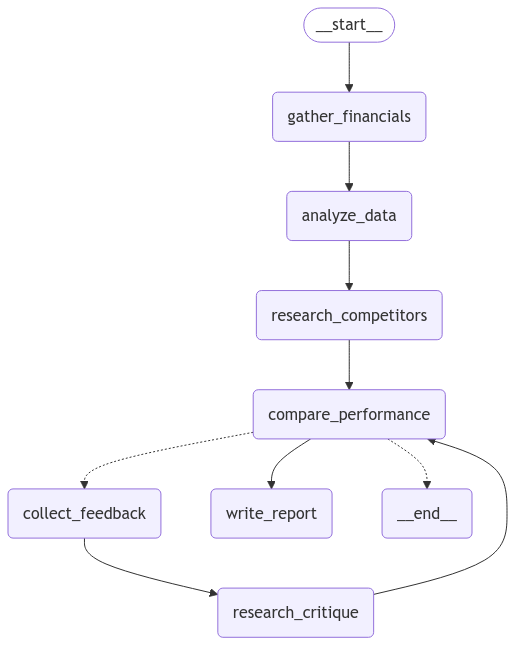

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def read_csv_file(file_path):
    with open(file_path, "r") as file:
        print("Reading CSV file...")
        return file.read()

task = "Analyze the financial performance of our (MegaAICo) company compared to competitors"
competitors = ["Microsoft", "Nvidia", "Google"]
csv_file_path = (
    "./data/financials.csv"  # Update with the actual path to your CSV file
)

if not os.path.exists(csv_file_path):
    print(f"CSV file not found at {csv_file_path}")
else:
    print("Starting the conversation...")
    csv_data = read_csv_file(csv_file_path)

    initial_state = {
        "task": task,
        "competitors": competitors,
        "csv_file": csv_data,
        "max_revisions": 2,
        "revision_number": 1,
    }
    thread = {"configurable": {"thread_id": "1"}}

    final_result = []
    for s in graph.stream(initial_state, thread):
        final_result.append(s)
        print(s)

Starting the conversation...
Reading CSV file...
{'gather_financials': {'financial_data': "To analyze MegaAICo's financial performance, we will summarize the key financial metrics from the provided data and compare it against typical benchmarks in the industry. The analysis will focus on revenue growth, profitability margins, and overall cost management.\n\n### MegaAICo Financial Summary (2018-2023)\n\n| Year | Revenue  | COGS    | Operating Expenses | Net Income | Gross Margin | Operating Margin | Net Margin |\n|------|----------|---------|-------------------|------------|--------------|-----------------|------------|\n| 2018 | 5,000,000 | 3,000,000 | 1,500,000         | 500,000    | 40%          | 10%             | 10%        |\n| 2019 | 5,500,000 | 3,200,000 | 1,600,000         | 700,000    | 42.86%       | 12.73%          | 12.73%     |\n| 2020 | 6,000,000 | 3,400,000 | 1,700,000         | 900,000    | 43.33%       | 15%             | 15%        |\n| 2021 | 6,500,000 | 3,600,000 | 

In [9]:
print(final_result[-1]["write_report"]["report"])

# Financial Performance Report of MegaAICo

**Prepared for: MegaAICo Stakeholders**  
**Date: October 31, 2023**

---

## Executive Summary

This report presents a comprehensive financial performance analysis of MegaAICo over the past six years (2018-2023) and benchmarks it against key competitors in the AI sector: TechAI Corp, InnovateAI, and SmartAI Solutions. The analysis focuses on key financial metrics, including revenue growth, gross margin, operating margin, net income, and net margin. The findings reveal MegaAICo's solid performance and strategic positioning within the highly competitive AI industry.

---

## Financial Performance Overview

### 1. Revenue Growth Analysis

- **MegaAICo:** 
  - Revenue increased from **$5 million** in 2018 to **$7.5 million** in 2023.
  - Total growth of **50%** with a **CAGR of 5.88%**.

- **Comparative Competitors:**
  - **TechAI Corp:** Revenue surged from **$4 million** to **$8 million** (100% growth; CAGR of 12.25%).
  - **InnovateAI:** Grew

In [7]:
df = pd.read_csv('./data/financials.csv')
df

,Year,Revenue,Cost of Goods Sold,Operating Expenses,Net Income
0,2018,5000000,3000000,1500000,500000
1,2019,5500000,3200000,1600000,700000
2,2020,6000000,3400000,1700000,900000
3,2021,6500000,3600000,1800000,1100000
4,2022,7000000,3800000,1900000,1300000
5,2023,7500000,4000000,2000000,1500000
